Liczba rekordów przed czyszczeniem: 2500
Liczba rekordów po czyszczeniu: 2500



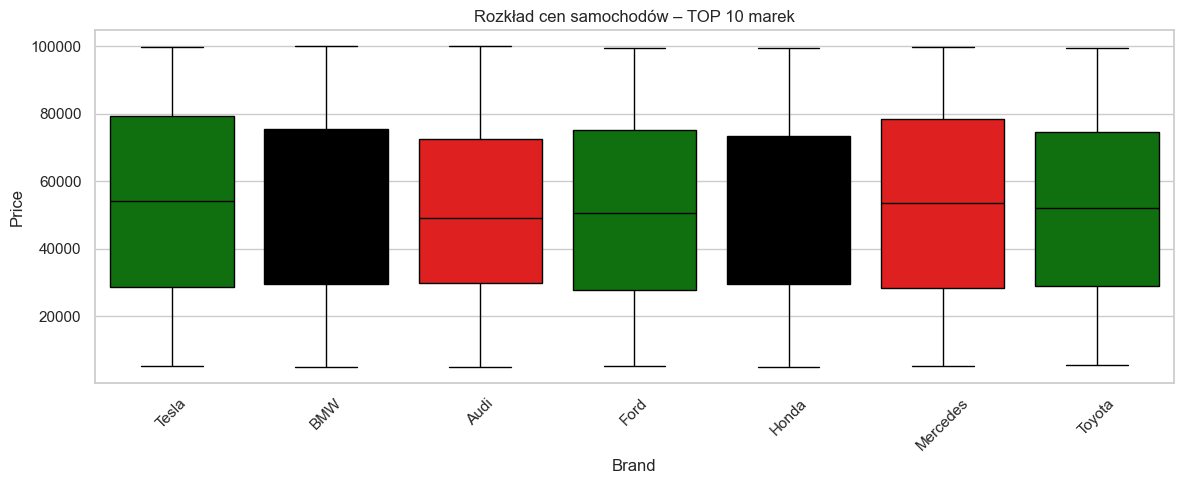

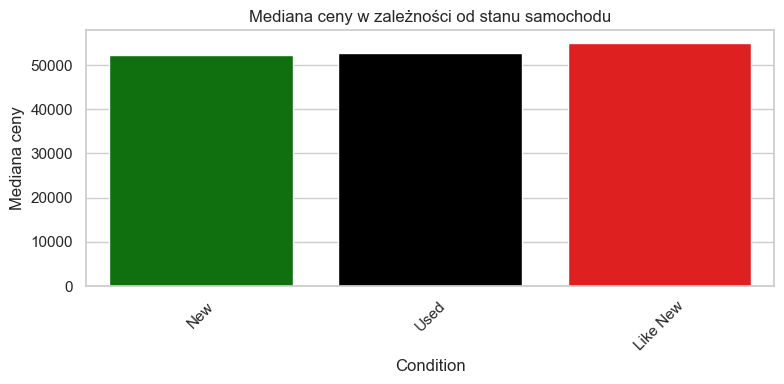


===== PODSUMOWANIE =====
Średnia cena samochodu: 52,638.02 zł
Najdroższa marka średnio: BMW (54,157.11 zł)
Korelacja przebieg–cena: -0.0086

Mediany cen wg stanu:
  Like New: 55,069.13 zł
  New: 52,264.40 zł
  Used: 52,840.27 zł


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")

#Kolory AGH do wizualizacji
agh_colors = ["green", "black", "red"]

#Wczytanie danych
df = pd.read_csv("car_price_prediction_.csv")
print(f"Liczba rekordów przed czyszczeniem: {len(df)}")
df.head()

#Podstawowy preprocessing
df = df.drop_duplicates()

#Konwersja wybranych kolumn na numeryczne (jeśli są jako stringi)
num_cols = ["Mileage", "Price", "Year"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

#Uzupełnienie braków: liczby medianą, kategorie modą
df = df.fillna(df.median(numeric_only=True))
df = df.fillna(df.mode().iloc[0])

#Usunięcie oczywistych błędów w danych
current_year = datetime.now().year
df = df[
    (df["Price"] > 0) &
    (df["Mileage"] >= 0) &
    (df["Year"].between(1950, current_year))
]

#Detekcja outlierów ceny (metoda IQR)
Q1, Q3 = df["Price"].quantile([0.25, 0.75])
IQR = Q3 - Q1
df = df[df["Price"].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)]

print(f"Liczba rekordów po czyszczeniu: {len(df)}\n")

#Feature engineering
df["Car_Age"] = (current_year - df["Year"]).clip(lower=1)
df["Value_per_year"] = df["Price"] / df["Car_Age"]

#Proste wizualizacje

#Boxplot cen dla najpopularniejszych marek
top_brands = df["Brand"].value_counts().head(10).index
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df[df["Brand"].isin(top_brands)],
    x="Brand",
    y="Price",
    hue="Brand",
    palette=(agh_colors * 4)[:len(top_brands)],
    showfliers=False,
    legend=False
)
plt.title("Rozkład cen samochodów – TOP 10 marek")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Mediana ceny w zależności od stanu pojazdu
condition_medians = df.groupby("Condition")["Price"].median().sort_values()

plt.figure(figsize=(8, 4))
sns.barplot(
    x=condition_medians.index,
    y=condition_medians.values,
    hue=condition_medians.index, 
    palette=agh_colors[:len(condition_medians)],
    legend=False 
)
plt.title("Mediana ceny w zależności od stanu samochodu")
plt.ylabel("Mediana ceny")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Wyniki analizy
mean_price = df["Price"].mean()
brand_avg = df.groupby("Brand")["Price"].mean()
best_brand = brand_avg.idxmax()
corr_mileage_price = df["Mileage"].corr(df["Price"])
condition_medians = df.groupby("Condition")["Price"].median()

print("\n===== PODSUMOWANIE =====")
print(f"Średnia cena samochodu: {mean_price:,.2f} zł")
print(f"Najdroższa marka średnio: {best_brand} ({brand_avg.max():,.2f} zł)")
print(f"Korelacja przebieg–cena: {corr_mileage_price:.4f}")
print("\nMediany cen wg stanu:")
for cond, val in condition_medians.items():
    print(f"  {cond}: {val:,.2f} zł")
